# Notebook to Look at Mixing

Todays notebook uses a simple vertical box (x and z dimensions) to look at what mixing and advection does to tracers.  We will start with a tracer we assume has no sources or sinks (salinity) and then consider a tracer with sources and sinks (oxygen).  
The **Learning Goal** is, for those who complete the exercises, to gain an intuitive physical understanding of the tracer patterns that arise due to mixing, advection and sources/sinks.

## 1. Imports and Functions

In [2]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Set up a Standard Plot
def make_a_plot(tracer, depths, distance, label):
    fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [3, 1, 1, 1]}, figsize=(15, 5))

    colours = axs[0].pcolormesh(distance, depths, tracer, cmap=cm.haline)
    
    axs[1].plot(tracer[:, 1], depths)

    mid = int(tracer.shape[1]/2)
    axs[2].plot(tracer[:, mid], depths)

    axs[3].plot(tracer[:, -2], depths)

    axs[0].set_ylabel('Depth (m)')
    cb = fig.colorbar(colours, ax=axs[0])
    cb.set_label(label)
    
    for ax in axs:
        ax.invert_yaxis()
    axs[0].set_xlabel('Distance (m)')
    for ax in axs[1:]:
        ax.set_xlabel(label);

    axs[1].text(0.03, 0.1, f'at Distance = {distance[1]:.0f} m', transform=axs[1].transAxes)
    axs[2].text(0.03, 0.1, f'at Distance = {distance[mid]:.0f} m', transform=axs[2].transAxes)
    axs[3].text(0.03, 0.1, f'at Distance = {distance[-2]:.0f} m', transform=axs[3].transAxes)

    axs[0].text(0.05, 0.2, f'integrated tracer = {tracer.mean() * (depths[-1] - depths[0]) * (distance[-1] - distance[0]):.0f}',
               transform=axs[0].transAxes)
    axs[1].text(0.05, 0.2, f'integrated tracer =\n {tracer[:,1].mean() * (depths[-1] - depths[0]):.0f}',
               transform=axs[1].transAxes)
    axs[2].text(0.05, 0.2, f'integrated tracer =\n {tracer[:,mid].mean() * (depths[-1] - depths[0]):.0f}',
               transform=axs[2].transAxes)
    axs[3].text(0.05, 0.2, f'integrated tracer =\n {tracer[:,-2].mean() * (depths[-1] - depths[0]):.0f}',
               transform=axs[3].transAxes)

In [4]:
def ss_mixing_and_advection(tracerT, sourceT, sinkT, kappa, uT, wT, depths, distance, time):
    tracer = tracerT.T
    kappah = (0.5 * (kappa[1:] + kappa[0:-1])).T # define Kappa half way between the tracer points
    u = uT.T
    w = wT.T
    source = sourceT.T
    sink = sinkT.T
    if kappa.max() > 0:
        dt = 0.1 * (depths[2] - depths[1])**2/kappa.max()
    else:
        dt = 100.
    if w.max() > 0.:
        dt = min(dt, 0.1 * (depths[2] - depths[1])/w.max())
    if u.max() > 0.:
        dt = min(dt, 0.1 * (distance[2] - distance[1])/u.max())
    usign = u > 0
    wsign = w > 0
    dx = distance[2] - distance[1]
    dz = depths[2] - depths[1]
    for tt in np.arange(0, time, dt):
        tracer[1:-1, 1:-1] = tracer[1:-1, 1:-1] + dt * ((
            kappah[1:-1, 0:-1] * (tracer[1:-1, 0:-2] - tracer[1:-1, 1:-1]) +
            kappah[1:-1, 1:] * (-tracer[1:-1, 1:-1] + tracer[1:-1, 2:])) /   (
            (depths[2:] - depths[1:-1]) * (depths[1:-1] - depths[0:-2]) ) +
            (usign[1:-1, 1:-1] * u[0:-2, 1:-1] * (tracer[0:-2, 1:-1] - tracer[1:-1, 1:-1])
            + (1 - usign[1:-1, 1:-1]) * u[2:, 1:-1] * (-tracer[2:, 1:-1] + tracer[1:-1, 1:-1]))/dx
            + (wsign[1:-1, 1:-1] * w[1:-1, 2:] * (tracer[1:-1, 2:] - tracer[1:-1, 1:-1])
            + (1 - wsign[1:-1, 1:-1]) * w[1:-1, 0:-2] * (-tracer[1:-1, 0:-2] + tracer[1:-1, 1:-1]))/dz
            - sink[1:-1, 1:-1] + source[1:-1, 1:-1]                                           
                                                       )
        # boundary conditions
        tracer[:, 0] = tracer[:, 0] + dt * kappah[:, 0] * (- tracer[:, 0] + tracer[:, 1]) / (
            (depths[1] - depths[0])**2 ) - sink[:, 0] * dt + source[:, 0] * dt
        tracer[:, -1] = tracer[:, -1] + dt * kappah[:, -1] * (tracer[:, -2] - tracer[:, -1]) / (
            (depths[-1] - depths[-2])**2 ) - sink[:, -1] * dt + source[:, -1] * dt
        tracer[0, :] = tracer[1, :]
        tracer[-1, :] = tracer[-2, :]

        # no negative values
        tracer[tracer < 0] = 0

    return tracer.T

In [5]:
def mixing_and_advection(tracerT, kappa, uT, wT, depths, distance, time):
    tracer = tracerT.T
    kappah = (0.5 * (kappa[1:] + kappa[0:-1])).T # define Kappa half way between the tracer points
    u = uT.T
    w = wT.T
    if kappa.max() > 0:
        dt = 0.1 * (depths[2] - depths[1])**2/kappa.max()
    else:
        dt = 1000.
    dt = min(dt, 0.1 * (depths[2] - depths[1])/w.max())
    dt = min(dt, 0.1 * (distance[2] - distance[1])/u.max())
    usign = u > 0
    wsign = w > 0
    dx = distance[2] - distance[1]
    dz = depths[2] - depths[1]
    for tt in np.arange(0, time, dt):
        tracer[1:-1, 1:-1] = tracer[1:-1, 1:-1] + dt * ((
            kappah[1:-1, 0:-1] * (tracer[1:-1, 0:-2] - tracer[1:-1, 1:-1]) +
            kappah[1:-1, 1:] * (-tracer[1:-1, 1:-1] + tracer[1:-1, 2:])) /   (
            (depths[2:] - depths[1:-1]) * (depths[1:-1] - depths[0:-2]) ) +
            (usign[1:-1, 1:-1] * u[0:-2, 1:-1] * (tracer[0:-2, 1:-1] - tracer[1:-1, 1:-1])
            + (1 - usign[1:-1, 1:-1]) * u[2:, 1:-1] * (-tracer[2:, 1:-1] + tracer[1:-1, 1:-1]))/dx
            + (wsign[1:-1, 1:-1] * w[1:-1, 2:] * (tracer[1:-1, 2:] - tracer[1:-1, 1:-1])
            + (1 - wsign[1:-1, 1:-1]) * w[1:-1, 0:-2] * (-tracer[1:-1, 0:-2] + tracer[1:-1, 1:-1]))/dz
                                                       )
        # boundary conditions
        tracer[:, 0] = tracer[:, 0] + dt * kappah[:, 0] * (- tracer[:, 0] + tracer[:, 1]) / (
            (depths[1] - depths[0])**2 )
        tracer[:, -1] = tracer[:, -1] + dt * kappah[:, -1] * (tracer[:, -2] - tracer[:, -1]) / (
            (depths[-1] - depths[-2])**2 )
        tracer[0, :] = tracer[1, :]
        tracer[-1, :] = tracer[-2, :]
    return tracer.T

In [6]:
def mixing(tracerT, kappa, depths, distance, time):
    tracer = tracerT.T
    kappah = (0.5 * (kappa[1:] + kappa[0:-1])).T # define Kappa half way between the tracer points
    dt = 0.1 * (depths[2] - depths[1])**2/kappa.max()
    for tt in np.arange(0, time, dt):
        tracer[:, 1:-1] = tracer[:, 1:-1] + dt * (
            kappah[:, 0:-1] * (tracer[:, 0:-2] - tracer[:, 1:-1]) +
            kappah[:, 1:] * (-tracer[:, 1:-1] + tracer[:, 2:])) /   (
            (depths[2:] - depths[1:-1]) * (depths[1:-1] - depths[0:-2]) )
        tracer[:, 0] = tracer[:, 0] + dt * kappah[:, 0] * (- tracer[:, 0] + tracer[:, 1]) / (
            (depths[1] - depths[0])**2 )
        tracer[:, -1] = tracer[:, -1] + dt * kappah[:, -1] * (tracer[:, -2] - tracer[:, -1]) / (
            (depths[-1] - depths[-2])**2 )
    return tracer.T

## 2. Set up Domain etc

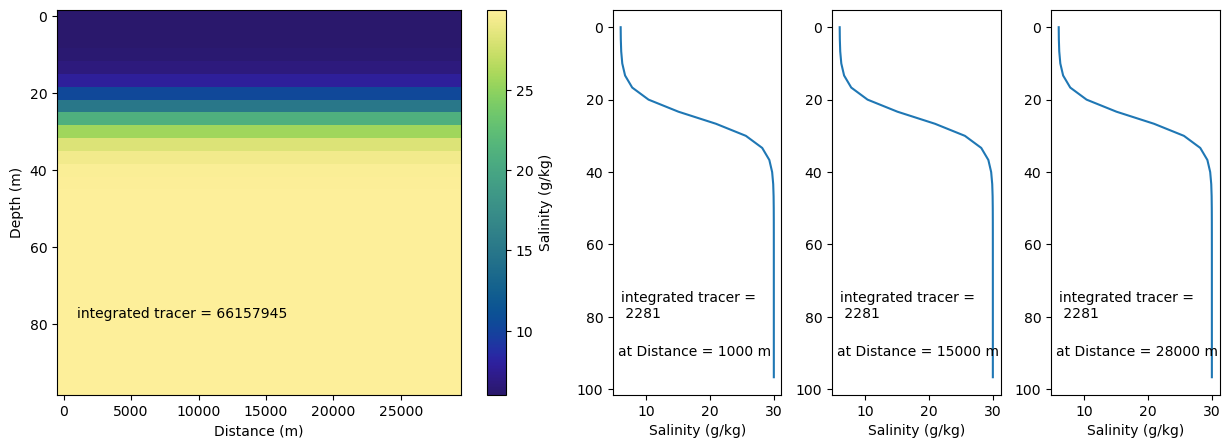

In [7]:
zsize, xsize = 30, 30

maxdepth  = 100 # m
depths = np.arange(0, maxdepth, maxdepth/zsize)

length = 30e3 # m
distance = np.arange(0, length, length/xsize)

salinity = np.empty((zsize, xsize))
for ii in range(zsize):
    salinity[ii, :] = 30/2 * (1.2 + 0.8 * np.tanh((ii/zsize-0.25)*zsize/2))
salinity0 = np.copy(salinity)
make_a_plot(salinity, depths, distance, 'Salinity (g/kg)')

## 3. Vertical Mixing Only

### 3.1 Constant Mixing Coefficient

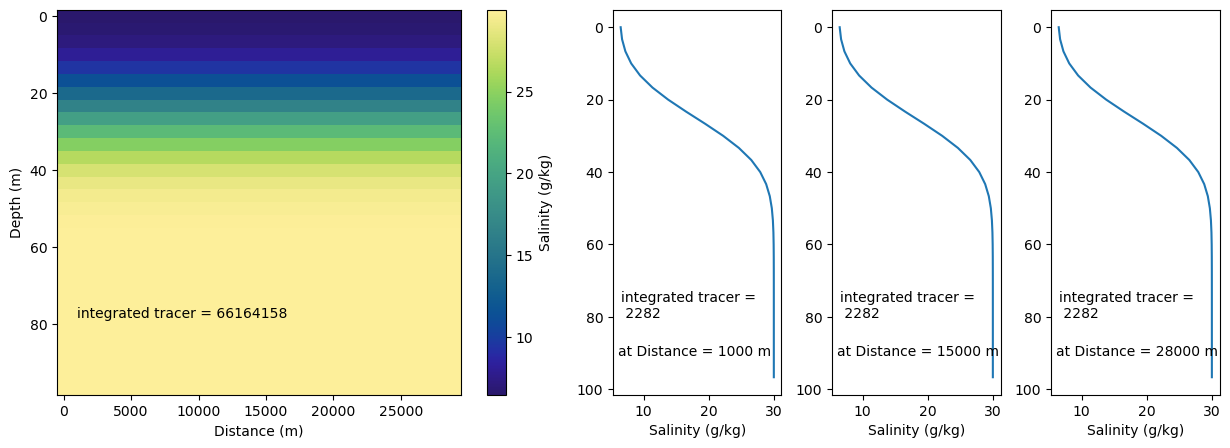

In [8]:
# First Lets take K as a constant
kappa = 1e-4 * np.ones_like(salinity)
newsalinity = mixing(salinity, kappa, depths, distance, 5*86400.)

make_a_plot(newsalinity, depths, distance, 'Salinity (g/kg)')

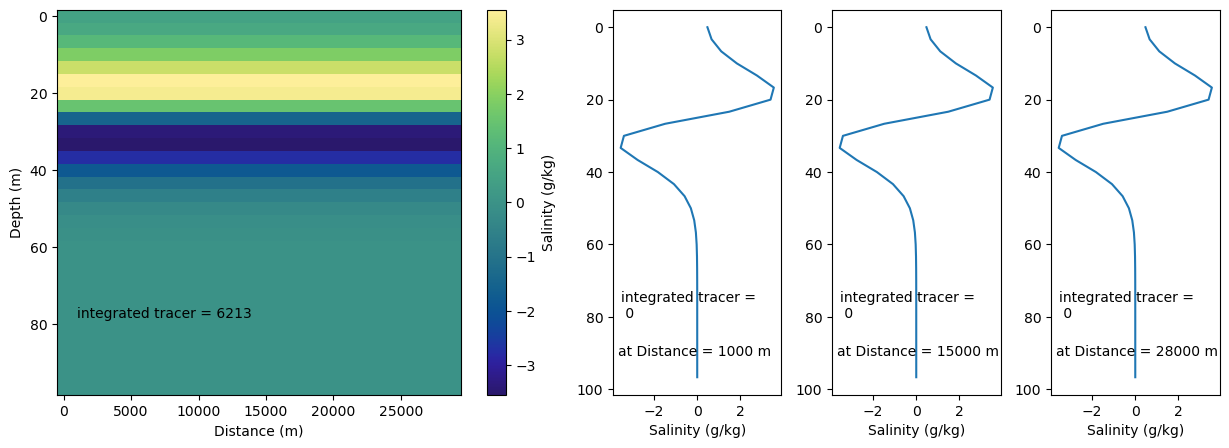

In [9]:
# Make a difference plot
make_a_plot(newsalinity - salinity0, depths, distance, 'Salinity (g/kg)')

### 3.2 Mixing Surface Intensified

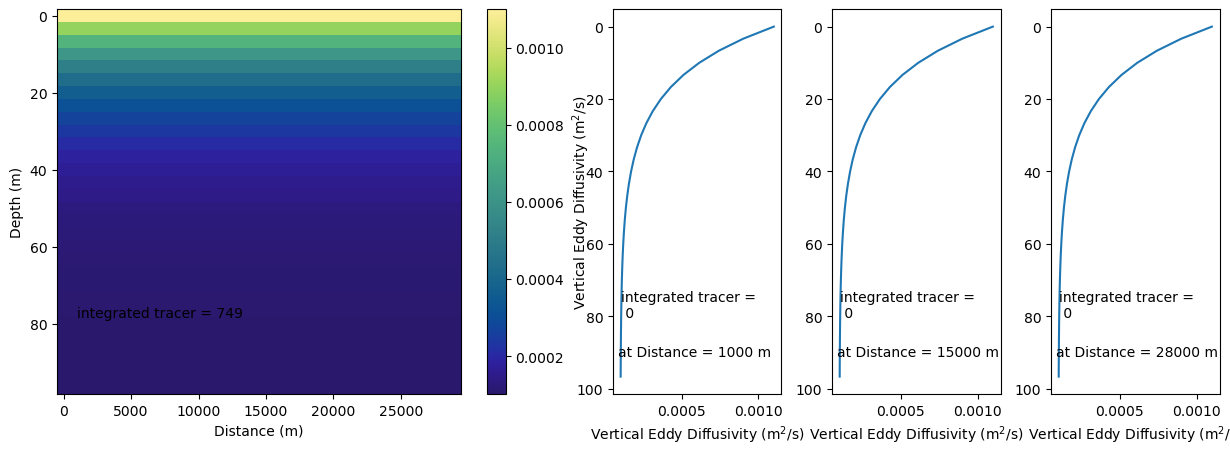

In [10]:
# Lets take K surface intensified
for ii in range(zsize):
    kappa[ii, :] = 1e-3 * np.exp(-depths[ii]/15) + 1e-4
make_a_plot(kappa, depths, distance, 'Vertical Eddy Diffusivity (m$^2$/s)')

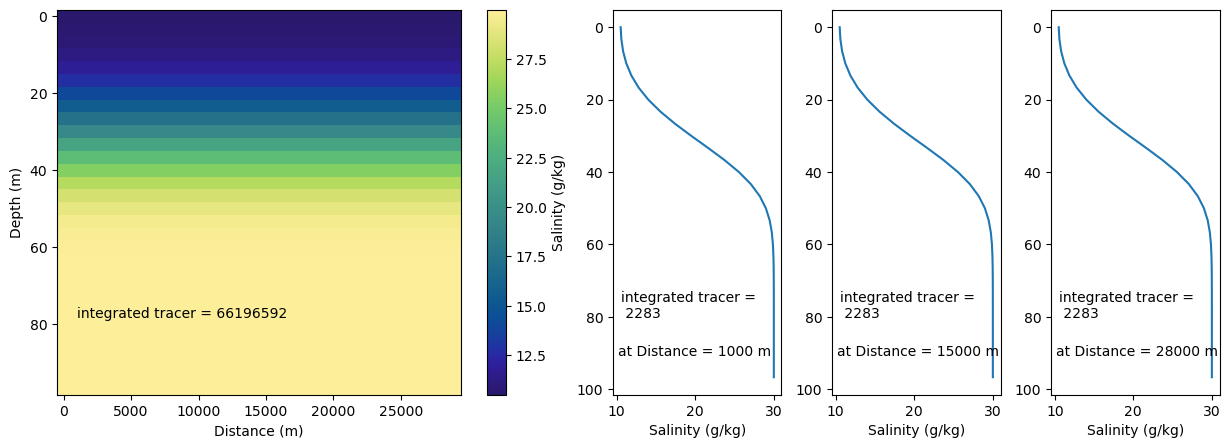

In [11]:
salinity = np.copy(salinity0)
newsalinity2 = mixing(salinity, kappa, depths, distance, 5*86400.)

make_a_plot(newsalinity2, depths, distance, 'Salinity (g/kg)')

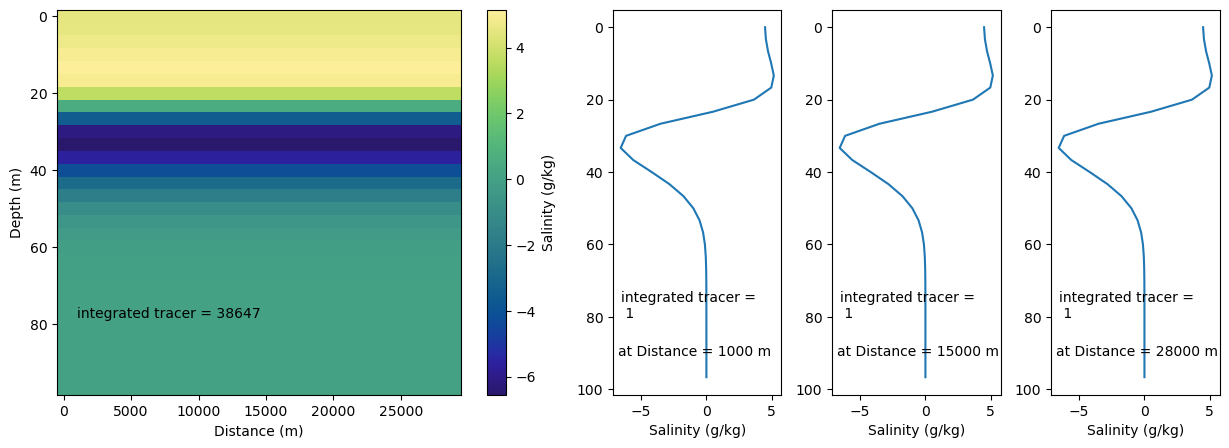

In [12]:
make_a_plot(newsalinity2 - salinity0, depths, distance, 'Salinity (g/kg)')

# Question 1 #

a) When just vertical mixing occurs, what type of patterns do you see?  
b) What is conserved in a vertical profile?  
c) How do things change is the vertical eddy diffuvisity is not constant?  
d) Try another type of vertical eddy diffusivity distribution using the cells below.  What do you see?  What happens if you change the eddy diffusivity in different distances across the box?  You can also try different salinity distributions if you have time

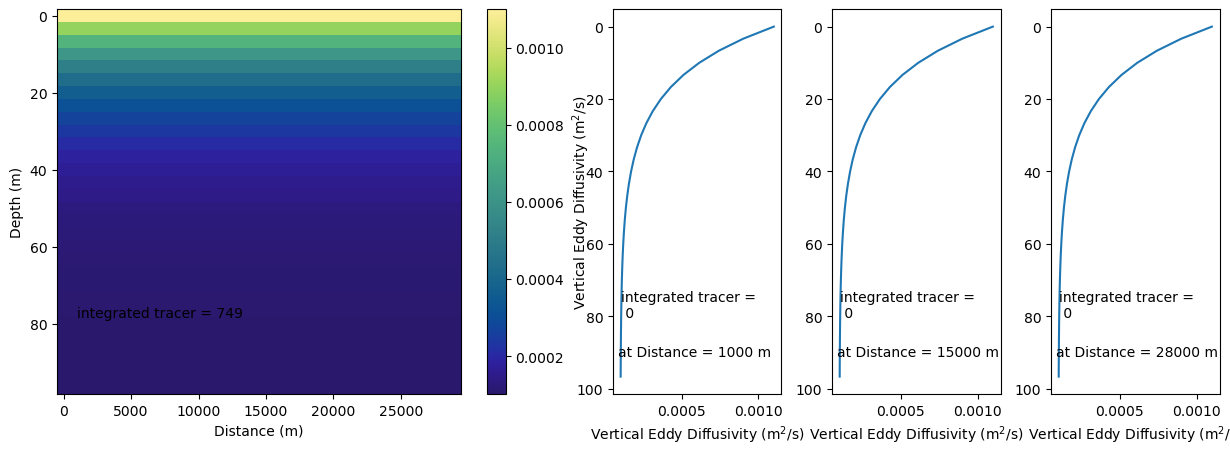

In [13]:
# Define your kappa

# check your kappa
make_a_plot(kappa, depths, distance, 'Vertical Eddy Diffusivity (m$^2$/s)')

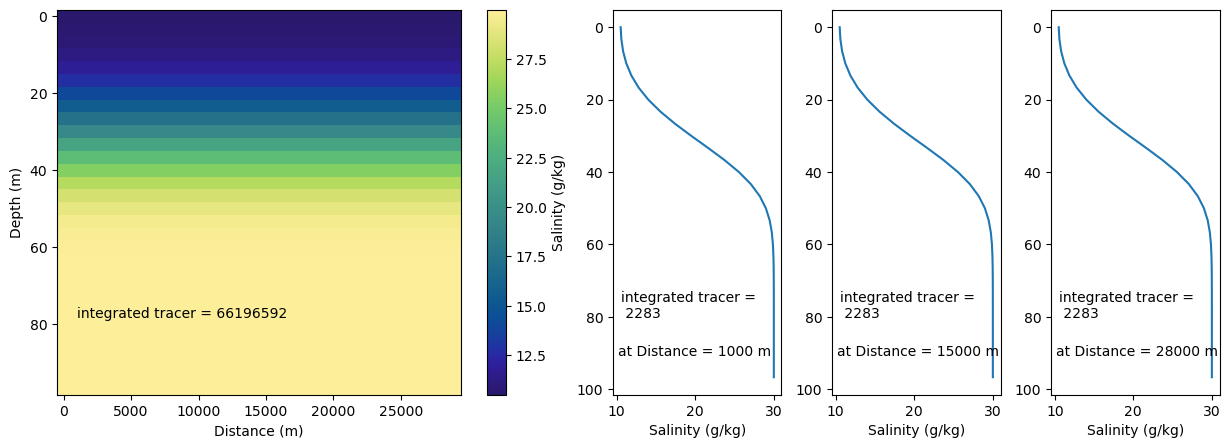

In [14]:
# Run and plot with your Kappa
salinity = np.copy(salinity0)
newsalinity2 = mixing(salinity, kappa, depths, distance, 5*86400.)

make_a_plot(newsalinity2, depths, distance, 'Salinity (g/kg)')

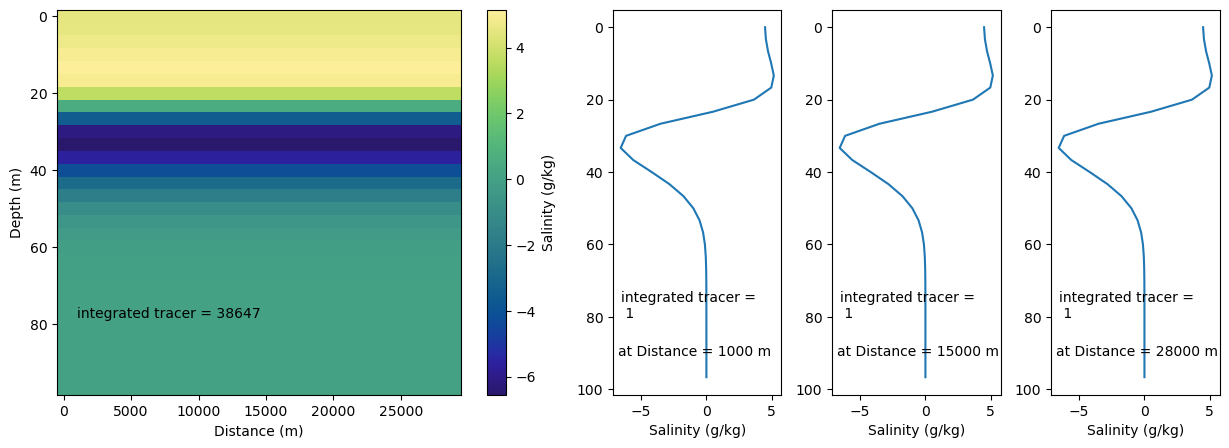

In [15]:
# and a difference plot
make_a_plot(newsalinity2 - salinity0, depths, distance, 'Salinity (g/kg)')

## 4. Advection

Note: Even with kappa=0, there is some numerical diffusivity

### 4.1 Set up a velocity field

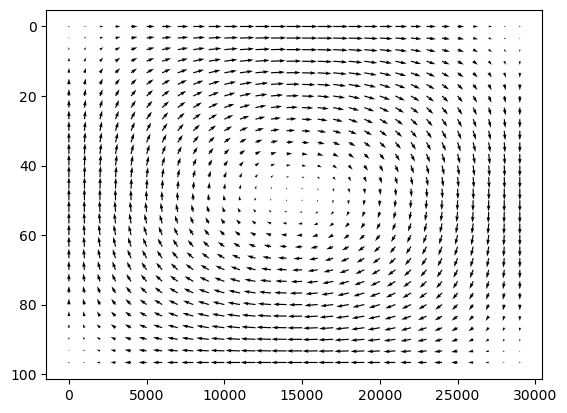

In [19]:
# add advection : this simple upwelling/downwelling cell conserves mass
u = np.zeros_like(salinity)
w = np.zeros_like(salinity)
umax = 0.05 # m/s
for ii in range(zsize):
    u[ii, :] = umax * np.sin(np.pi * distance/(distance[-1] - distance[0])) * np.cos(np.pi * depths[ii]/(depths[-1] - depths[0]))
    w[ii, :] = -umax * (depths[-1] - depths[0]) / (distance[-1] - distance[0]) * (
        np.cos(np.pi * distance/(distance[-1] - distance[0])) * np.sin(np.pi * depths[ii]/(depths[-1] - depths[0])) )
plt.quiver(distance, depths, u, w, angles='xy', scale_units='xy');
plt.gca().invert_yaxis();

### 4.2 Advection Only

In [ ]:
# Advection
salinity = np.copy(salinity0)
kappa = np.zeros_like(kappa)
# note we are running for half a day, before it was 5 days
newsalinity2 = mixing_and_advection(salinity, kappa, u, w, depths, distance, 0.5*86400.)

make_a_plot(newsalinity2, depths, distance, 'Salinity (g/kg)')

In [ ]:
make_a_plot(newsalinity2-salinity0, depths, distance, 'Salinity (g/kg)')

# Question 2

a) When just advection occurs what type of patterns do you see?  
b) If you just had one profile but at two different times, say the one at Distance = 28000 m at time=0 (newsalinity) and time=1/2 day), what things could you look at to tell you if it was mixing or advecting?  
c) If you have time, think about other plots you might like to have?  Can you code them?

### 4.3 Mixing and Advection

In [ ]:
# Constant Kappa
kappa = 1e-4 * np.ones_like(salinity)
salinity = np.copy(salinity0)
newsalinity2 = mixing_and_advection(salinity, kappa, u, w, depths, distance, 0.5*86400.)

make_a_plot(newsalinity2, depths, distance, 'Salinity (g/kg)')

In [ ]:
# Difference plot
make_a_plot(newsalinity2-salinity0, depths, distance, 'Salinity (g/kg)')

# Question 3

a) How does mixing the two complicate things?  How does your test for mixing versus advection from Q2 fair?  
b) Which is dominating in this case?  Can you make the other dominate (but not be zero)?  
c) If you have extra time: run your new plot, vary kappa or vary the salinity distribution.

## 5. Sources and Sinks

Let's change to oxygen and assume we have a source at a shallow chl max layer and a sink at the bottom.

In [ ]:
oxygen0 = 150 * np.ones_like(salinity)  # I'm using mmol/m3 here, but change to your preferred units
source = np.zeros_like(salinity)
sink = np.zeros_like(salinity)
source[1:4, :] = 5/86400. # mmol/m3/s
sink[-2:, :] = 15/86400. # mmol/m3/s

In [ ]:
make_a_plot(oxygen0, depths, distance, 'Oxygen (mmol/m$^3$)')

### 5.1 Sources and Sinks Only

In [ ]:
# set the vert eddy diffusivity and the velocities to zero
kappa0 = np.zeros_like(salinity)
u0 = np.zeros_like(u)
w0 = np.zeros_like(w)

oxygen = np.copy(oxygen0)
newoxygen = ss_mixing_and_advection(oxygen, source, sink, kappa0, u0, w0, depths, distance, 0.5*86400.)
make_a_plot(newoxygen, depths, distance, 'Oxygen (mmol/m$^3$)')

### 5.2 Sources and Sinks with Mixing 

In [ ]:
# set the vert eddy diffusivity to 1e-4 and the velocities to zero
kappa = 1e-4 * np.ones_like(salinity)
u0 = np.zeros_like(u)
w0 = np.zeros_like(w)

oxygen = np.copy(oxygen0)
newoxygen = ss_mixing_and_advection(oxygen, source, sink, kappa, u0, w0, depths, distance, 0.5*86400.)
make_a_plot(newoxygen, depths, distance, 'Oxygen (mmol/m$^3$)')

In [ ]:
# Run for much longer
oxygen = np.copy(oxygen0)
oxygen_profile = ss_mixing_and_advection(oxygen, source, sink, kappa, u0, w0, depths, distance, 15*86400.)
make_a_plot(oxygen_profile, depths, distance, 'Oxygen (mmol/m$^3$)')

### 5.3 And include advection

In [ ]:
# Here we will add an upwelling/downwelling day to the profile we had above
oxygen = np.copy(oxygen_profile)
newoxygen = ss_mixing_and_advection(oxygen, source, sink, kappa, u, w, depths, distance, 1*86400.)
make_a_plot(newoxygen, depths, distance, 'Oxygen (mmol/m$^3$)')

# Question 5 ....

a) When there is just sources and sinks what type of patterns do you see?   
b) How does that change with mixing?  
c) With advection?  
d) If you have time, try other source/sink variations.